In [3]:
from functools import reduce
import pandas as pd 
import itertools as it
from brent import Query, DAG, SupposeQuery
from brent.common import make_fake_df

In [4]:
grade = ["good", "pass", "fail"]
study = ["lots", "little", "no"]
hard = ["yes", "no"]
probs = [0.6, 0.3, 0.1, 
         0.9, 0.09, 0.01, 
         0.3, 0.3, 0.4, 
         0.6, 0.2, 0.2, 
         0.1, 0.3, 0.6, 
         0.1, 0.5, 0.4]
zipprod = zip(it.product(study, hard, grade), probs)
tween = reduce(lambda a,b: a+b, [[c]*int(p * 100) for c, p in zipprod])
df = pd.DataFrame(tween, columns=["study", "hard", "grade"])
dag = (DAG(df)
       .add_edge("study", "grade")
       .add_edge("hard", "grade"))
dag.plot()

ValueError: Grouper and axis must be same length

In [14]:
df.groupby(list(df.columns)).agg(len).reset_index()

,study,hard,grade,0
0,little,no,fail,20
1,little,no,good,60
2,little,no,pass,20
3,little,yes,fail,40
4,little,yes,good,30
5,little,yes,pass,30
6,lots,no,fail,1
7,lots,no,good,90
8,lots,no,pass,9
9,lots,yes,fail,10


In [3]:
q = Query(dag).given(study="lots", grade="pass")
q.infer()

{'hard': {'no': 0.2307692307692308, 'yes': 0.7692307692307693},
 'study': {'lots': 1.0},
 'grade': {'pass': 1.0}}

In [4]:
p_not_hard, p_hard = q.infer()['hard']['no'], q.infer()['hard']['yes']

In [5]:
for studied in ['little', 'no']:
    v1 = 1 - Query(dag).given(hard="yes", study=studied).infer()['grade']['fail']
    v2 = 1 - Query(dag).given(hard="no", study=studied).infer()['grade']['fail']
    print(f"p(grade=pass|study={studied}, do(study=lots) -> grade=pass) = {v1*p_hard + v2*p_not_hard}")

p(grade=pass|study=little, do(study=lots) -> grade=pass) = 0.6461538461538462
p(grade=pass|study=no, do(study=lots) -> grade=pass) = 0.44615384615384623


# Jonatan and Vincent

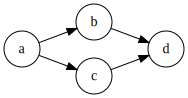

In [6]:
from brent.common import make_fake_df

df = make_fake_df(nodes=4, rows=100, values=2)
dag = DAG(df).add_edge("a", "b").add_edge("a", "c").add_edge("c", "d").add_edge("b", "d")
dag.plot()

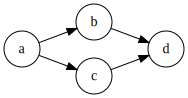

In [7]:
import random

def simulate_row():
    a = int(random.random() > 0.2)
    b_lim = 0.5 + 0.2 * a
    c_lim = 0.5 - 0.03 * a
    b = int(random.random() < b_lim)
    c = int(random.random() > c_lim)
    d_lim = 0.5 - 0.2*b - 0.1*c
    d = int(random.random() > d_lim)
    return a, b, c, d

df = pd.DataFrame([simulate_row() for _ in range(1_000_000)], columns=list("abcd"))
dag = DAG(df).add_edge("a", "b").add_edge("a", "c").add_edge("c", "d").add_edge("b", "d").cache()
dag.plot()

In [8]:
q = Query(dag=dag)
q.infer(give_table=True)

,c,a,b,d,prob
0,0,0,0,0,0.024807
1,0,0,0,1,0.024905
2,0,0,1,1,0.034909
3,0,0,1,0,0.014966
4,0,1,0,0,0.056470
5,0,1,0,1,0.056693
6,0,1,1,1,0.184142
7,0,1,1,0,0.078945
8,1,0,0,0,0.020022
9,1,0,0,1,0.030050


# A SOLUTION?!

In [11]:
dag_copy = dag.copy().cache()
s = SupposeQuery(dag_copy).when(q)
orig_query_table = s.orig_query.infer(give_table=True)
names_to_omit = list(s.orig_query.given_dict.keys()) + list(s.orig_query.do_dict.keys())
names_to_join = [n for n in s.orig_query.dag.nodes if n not in names_to_omit]

for node in names_to_join:
    associated_table = dag_copy.prob_tables[node]
    colnames = list(associated_table.columns)
    res = (orig_query_table[colnames]
           .groupby([_ for _ in colnames if _ != "prob"])
           .sum()["prob"]
           .reset_index())
    dag_copy.prob_tables[node] = res

new_query = Query(dag=dag_copy, given=s.suppose_given_dict, do=s.suppose_do_dict)

new_query.infer(give_table=True)

,c,a,b,d,prob
0,0,0,0,0,0.024807
1,0,0,0,1,0.024905
2,0,0,1,1,0.034909
3,0,0,1,0,0.014966
4,0,1,0,0,0.056470
5,0,1,0,1,0.056693
6,0,1,1,1,0.184142
7,0,1,1,0,0.078945
8,1,0,0,0,0.020022
9,1,0,0,1,0.030050


In [28]:
dag_copy.prob_tables

{}

In [21]:
dag.prob_tables['a']

,a,prob
0,1,0.8005
1,0,0.1995


In [22]:
dag.prob_tables['c']

,a,c,prob
0,1,0,0.470262
1,0,1,0.499734
2,1,1,0.529738
3,0,0,0.500266


In [17]:
orig_query_table

,a,c,b,d,prob
2,0,0,1,1,0.092857
6,0,1,1,1,0.106006
10,1,0,1,1,0.350246
14,1,1,1,1,0.450891


In [9]:
SupposeQuery(dag).when(q).infer(give_table=True)

,c,a,b,d,prob
0,0,0,0,1,0.005161
1,0,0,0,0,0.005198
2,0,0,1,0,0.001864
3,0,0,1,1,0.010161
4,0,1,0,1,0.026162
5,0,1,0,0,0.026347
6,0,1,1,0,0.051577
7,0,1,1,1,0.281131
8,1,0,0,1,0.007385
9,1,0,0,0,0.003290


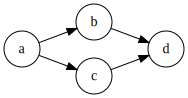

In [10]:
q = Query(dag=dag)
q.plot()

In [11]:
Query(dag=dag).infer(give_table=True)

,c,a,b,d,prob
0,0,0,0,1,0.024966
1,0,0,0,0,0.025054
2,0,0,1,0,0.015004
3,0,0,1,1,0.035030
4,0,1,0,1,0.056208
5,0,1,0,0,0.056407
6,0,1,1,0,0.078922
7,0,1,1,1,0.184257
8,1,0,0,1,0.029864
9,1,0,0,0,0.019931


In [12]:
Query(dag=dag).do(b=1).given(d=0).infer()

{'c': {0: 0.5768922561859822, 1: 0.42310774381401783},
 'a': {0: 0.20170169959411371, 1: 0.7982983004058863},
 'b': {1: 1.0},
 'd': {0: 1.0}}

In [13]:
s = SupposeQuery(dag).when(q).suppose_do(c=0)
s.infer()

{'c': {0: 1.0},
 'a': {0: 0.05163387767234301, 1: 0.9483661223276569},
 'b': {0: 0.1531651009520938, 1: 0.8468348990479062},
 'd': {0: 0.20812958895821804, 1: 0.791870411041782}}

In [14]:
s = SupposeQuery(dag).when(q).suppose_do(b=0)
s.infer()

{'c': {0: 0.4355912979017062, 1: 0.5644087020982937},
 'a': {0: 0.09353141182989053, 1: 0.9064685881701096},
 'b': {0: 1.0},
 'd': {0: 0.3924950270545223, 1: 0.6075049729454777}}